In [1]:
__author__ = 'T. Sánchez-Pastor'
__date__   = '19 de Julio de 2021'
# Modules
import numpy as np
import matplotlib.pyplot as plt
from math import pi, factorial
from numpy import sqrt
from scipy.special import gamma, hyp2f1, poch
import os
from numba import njit, prange
from atomic_units import ao, vo, e, hbar, me, Eh, to
from utils import A3D_int, B1_3D, B2_3D, separate_levels, en

The energy spectrum solution for a two identical-ultracold atoms in completely anisotropic traps is:

$$J_{3D} = 4 \pi \left[ W_{3D}(E) + \int^\infty_0 d\beta\  I_{3D}(E, \beta)\right]$$

with $J_{3D} = \frac{1}{a_{3D}}$. The functions $W_{3D}$ and $I_{3D}$ are defined as follows:

$$W_{3D} = -\frac{\pi}{2} \sqrt{\frac{\eta_x \eta_y \eta_z}{2}} \sum_{(n_x, n_y) \in C^{3D}_E} \left[ \frac{2^{n_x+n_y-1} \Gamma\left(\frac{1}{4} - \frac{E - \epsilon_{n_x} - \epsilon_{n_y}}{2}\right)}{\Gamma \left(\frac{1-n_x}{2}\right)^2 \Gamma\left(\frac{1-n_y}{2}\right)^2 \Gamma\left(n_x + 1\right) \Gamma\left(n_y + 1\right) \Gamma\left(\frac{3}{4} - \frac{E- \epsilon_{n_x} - \epsilon_{n_y}}{2}\right)}    \right],$$

$$ I_{3D} = -e^{\beta E} \prod_{\alpha=x,y,z}\sqrt{\frac{\eta_\alpha}{4\pi \sinh(\eta_\alpha\beta)}} + \left(\frac{1}{4\pi \beta}\right)^{3/2} + \sqrt{\frac{\pi\eta_x \eta_z}{8\sinh(\beta)}} \sum_{(n_x, n_y) \in C^{3D}_E} \left[ \frac{2^{n_x + n_y - 1/2} e^{\beta(E - \epsilon_{n_x} - \epsilon_{n_y})}}{\Gamma \left(\frac{1-n_x}{2}\right)^2 \Gamma\left(\frac{1-n_y}{2}\right)^2 \Gamma\left(n_x + 1\right) \Gamma\left(n_y + 1\right)} \right]$$

where, $\epsilon_{n_j} = \eta_j(n_j + 1/2)$, $\eta_j$ the anisotropies with respect the constant axis and $C^{3D}_E : \left\{ (n_x, n_y)|n_{x,y} = 0, 2, 4, 6, ...; \epsilon_{n_x} + \epsilon_{n_y} + 1/2 \leq E\right\}$.

There are some techniques which may speed up the calculation for the function $J_{3D}$. First,
$$J_{3D}(E) = 4\pi\left[ \int^\Lambda_0 A_{3D}d\beta + B^{(1)}_{3D}(E, \Lambda) + B^{(2)}_{3D}(E, \Lambda + \left(\frac{1}{2\pi} \right)^{3/2}\frac{1}{\sqrt{2\Lambda}}\right]$$

where $\Lambda$ is an arbitrary finite positive number, and the functions are defined as

$$A_{3D} = -e^{\beta E}\prod_\alpha \sqrt{\frac{\eta_\alpha}{4\pi \sinh(\eta_\alpha \beta)}} + \left(\frac{1}{4\pi \beta} \right)^{3/2};$$

$$B^{(1)}_{3D} = (-1) \sum_{(n_x, n_y) \in C^{3D}_E}\left\{ \frac{2^{n_x + n_y - 5/2} \sqrt{\pi \eta_x \eta_z}\ \Gamma\left(\frac{1}{4} - \frac{E - \epsilon_{n_x} - \epsilon_{n_y}}{2}\right) e^{(E - \epsilon_{n_x} - \epsilon_{n_y} - 3/2)\Lambda} }{\Gamma \left(\frac{1-n_x}{2}\right)^2 \Gamma\left(\frac{1-n_y}{2}\right)^2 \Gamma\left(n_x + 1\right) \Gamma\left(n_y + 1\right) \Gamma\left(\frac{5}{4} - \frac{E- \epsilon_{n_x} - \epsilon_{n_y}}{2}\right)} \\ \sqrt{e^{2\Lambda} - 1} _2F^1 \left[1, \frac{3}{4} - \frac{E- \epsilon_{n_x} - \epsilon_{n_y}}{2}, \frac{5}{4} - \frac{E- \epsilon_{n_x} - \epsilon_{n_y}}{2}, e^{-2\Lambda} \right] \right\}$$

$$ B^{(2)}_{3D} = \sqrt{\pi \eta_x \eta_z cosch \Lambda} \sum_{(n_x, n_y) \in C^{3D}_E} \frac{2^{n_x + n_y - 1} e^{(E - \epsilon_{n_x} - \epsilon_{n_y} - 2)\Lambda} (e^{2\Lambda - 1}) _2F^1\left[1, \frac{3}{4} - \frac{E- \epsilon_{n_x} - \epsilon_{n_y}}{2}, \frac{5}{4} - \frac{E- \epsilon_{n_x} - \epsilon_{n_y}}{2}, e^{-2\Lambda} \right] }{\Gamma \left(\frac{1-n_x}{2}\right)^2 \Gamma\left(\frac{1-n_y}{2}\right)^2 \Gamma\left(n_x + 1\right) \Gamma\left(n_y + 1\right) [2(E - \epsilon_{n_x} - \epsilon_{n_y}) - 1]} $$

In [2]:
# Parameters:
eta_x  = 1
eta_y  = 1
eta_z  = 1
nx     = 50
ny     = 50
nz     = 0
Eo = 1/2*(eta_x + eta_y + eta_z)
E      = np.linspace(-7.5, 12, num=200)

In [6]:
def B1_3D(nx, ny, etax, etay, E, Lambda):
    #np.seterr('raise')
    suma = 0
    for i in range(0, nx+1, 2):
        for j in range(0, ny+1, 2):
            if en(i, etax) + en(j, etay) + 1/2 <= E:
                suma += 2**(i + j - 5/2) * sqrt(pi*etax*etay) * gamma(1/4 - (E - en(i, etax) - en(j, etay))/2) *\
                       np.exp((E - en(i, etax) - en(j, etay) - 3/2)*Lambda) / (gamma((1-i)/2)**2 * gamma((1-j)/2)**2 \
                       * gamma(1+i) * gamma(1+j) * gamma(5/4 - (E - en(i, etax) - en(j, etay))/2)) * sqrt(np.exp(2*Lambda) - 1)*\
                        hyp2f1(1, 3/4 - (E - en(i, etax) - en(j, etay))/2, 5/4 - (E - en(i, etax) - en(j, etay))/2, np.exp(-2*Lambda))
    return (-1) * suma

def B2_3D(nx, ny, etax, etay, E, Lambda):
    suma = 0
    for i in range(0, nx+1):
        for j in range(0, ny+1):
            if (en(i, etax) + en(j, etay) + 1/2 >= E) or ((i%2 != 0) and (j%2 != 0) and (en(i, etax) + en(j, etay) + 1/2 <= E)):
                suma += 2**(i + j - 1) * (np.exp(2*Lambda) - 1) * hyp2f1(1, 3/4 - (E - en(i, etax) - en(j, etay))/2,\
                        5/4 - (E - en(i, etax) - en(j, etay))/2, np.exp(-2*Lambda)) / (gamma((1-i)/2)**2 * gamma((1-j)/2)**2 * gamma(1+i) * gamma(1+j) * (2*(E - en(i, etax) - en(j, etay)) - 1))
    return sqrt(pi*etax*etay/np.sinh(Lambda)) * suma

In [8]:
a3D = []
A3D_list = []
for e in E:
    integral = 0
    if e >= 1/2*(eta_x + eta_y + eta_z):
        Lambda = 10/(e - Eo)
        beta   = np.linspace(1e-6, Lambda, num=1000)
        A3D    = - np.exp(np.float128(beta*e)) * np.sqrt(eta_x*eta_y*eta_z/((4*pi)**3*np.float128(np.sinh(eta_x*beta))*np.float128(np.sinh(eta_y*beta))*np.float128(np.sinh(eta_z*beta)))) + 1/(4*pi*beta)**(3/2)
        integral = np.trapz(A3D)
        A3D_list.append(integral)
    else:
        Lambda = 3
        beta   = np.linspace(1e-6, Lambda, num=50000)
        A3D    = - np.exp(beta*e) * np.sqrt(eta_x*eta_y*eta_z/((4*pi)**3*np.sinh(eta_x*beta)*np.sinh(eta_y*beta)*np.sinh(eta_z*beta))) + 1/(4*pi*beta)**(3/2)
        integral = np.trapz(A3D)
        A3D_list.append(integral)

    J3D = sqrt(2)*4*pi*(integral + B1_3D(nx, ny, eta_x, eta_y, e, Lambda) + B2_3D(nx, ny, eta_x, eta_y, e, Lambda) + (1/(2*pi))**3/2 * 1/sqrt(2*Lambda))
    a3D.append(1/J3D)
E   = np.array(E)[~np.isnan(np.array(a3D))]
a3D = np.array(a3D)[~np.isnan(np.array(a3D))]

<ipython-input-6-06aa1d09168f>:9: RuntimeWarning: overflow encountered in exp
  * gamma(1+i) * gamma(1+j) * gamma(5/4 - (E - en(i, etax) - en(j, etay))/2)) * sqrt(np.exp(2*Lambda) - 1)*\
<ipython-input-6-06aa1d09168f>:18: RuntimeWarning: overflow encountered in exp
  suma += 2**(i + j - 1) * (np.exp(2*Lambda) - 1) * hyp2f1(1, 3/4 - (E - en(i, etax) - en(j, etay))/2,\
<ipython-input-6-06aa1d09168f>:18: RuntimeWarning: invalid value encountered in double_scalars
  suma += 2**(i + j - 1) * (np.exp(2*Lambda) - 1) * hyp2f1(1, 3/4 - (E - en(i, etax) - en(j, etay))/2,\


1


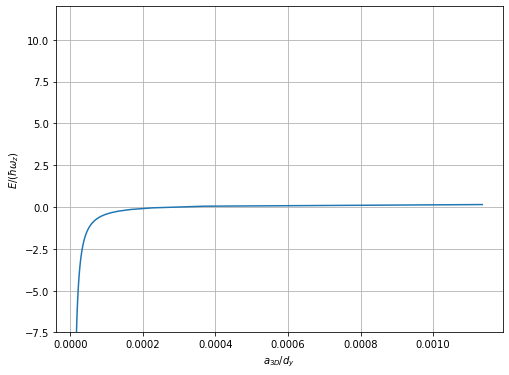

In [9]:
Spectrum, level = separate_levels(a3D, E)
fig, ax = plt.subplots(figsize=(8,6))
for i in range(1, level+1):
    print(i)
    ax.plot(Spectrum[f'a3D_n{i}'], Spectrum[f'E_n{i}'], 'C0')
ax.set_xlabel(r'$a_{3D}/d_y$')
ax.set_ylabel(r'$E/(\hbar \omega_z)$')
#ax.set_xlim(-10, 10)
ax.set_ylim(-7.5, 12)
plt.grid()

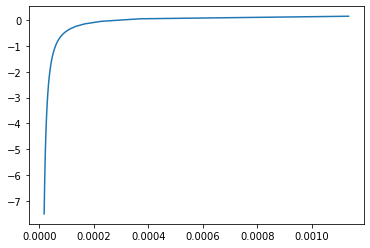

In [10]:
plt.plot(Spectrum[f'a3D_n{i}'], Spectrum[f'E_n{i}'])

In [8]:
Lambda = 10/(E - Eo)

In [10]:
np.exp(-2*Lambda)

array([2.40830046e-165, 4.90744380e-083, 1.34040763e-055, 7.00531498e-042,
       1.19218083e-033, 3.66115777e-028, 3.04159597e-024, 2.64675556e-021,
       5.11774878e-019, 3.45279717e-017, 1.08318084e-015, 1.91341521e-014,
       2.17297468e-013, 1.74401719e-012, 1.06034545e-011, 5.14466282e-011,
       2.07286594e-010, 7.15384427e-010, 2.16710278e-009, 5.87605069e-009,
       1.44888475e-008, 3.29117128e-008, 6.96118335e-008, 1.38326252e-007,
       2.60176715e-007, 4.66151766e-007, 7.99882732e-007, 1.32061243e-006,
       2.10623713e-006, 3.25629460e-006, 4.89477352e-006, 7.17263050e-006,
       1.02699183e-005, 1.43974510e-005, 1.97979537e-005, 2.67466713e-005,
       3.55514276e-005, 4.65521512e-005, 6.01198962e-005, 7.66554022e-005,
       9.65872436e-005, 1.20369629e-004, 1.48479908e-004, 1.81415856e-004,
       2.19692784e-004, 2.63840546e-004, 3.14400484e-004, 3.71922374e-004,
       4.36961401e-004, 5.10075206e-004, 5.91821046e-004, 6.82753078e-004,
       7.83419795e-004, 8